#Assignment 1 : Introduction to Deep learning by Ninad Sharma

In [3]:
import tensorflow as tf

In [4]:
tf.Tensor

tensorflow.python.framework.ops.Tensor

In [6]:
print(tf.math.add(1, 2))
print(tf.math.add([1, 2], [3, 4]))
print(tf.math.square(5))
print(tf.math.reduce_sum([1, 2, 3]))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


In [7]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.math.multiply(ndarray, 42)
print(tensor)


print("And NumPy operations convert Tensors to NumPy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
And NumPy operations convert Tensors to NumPy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]


In [8]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


In [10]:
ds_tensors = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])

# Create a CSV file
import tempfile
_, filename = tempfile.mkstemp()

with open(filename, 'w') as f:
  f.write("""Line 1
Line 2
Line 3
  """)

ds_file = tf.data.TextLineDataset(filename)

In [14]:
print(ds_file.batch(1))

<_BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>


In [15]:
ds_tensors = ds_tensors.map(tf.math.square).shuffle(2).batch(2)

ds_file = ds_file.batch(2)

In [16]:
print('Elements of ds_tensors:')
for x in ds_tensors:
  print(x)

print('\nElements in ds_file:')
for x in ds_file:
  print(x)

Elements of ds_tensors:
tf.Tensor([4 1], shape=(2,), dtype=int32)
tf.Tensor([ 9 16], shape=(2,), dtype=int32)
tf.Tensor([25 36], shape=(2,), dtype=int32)

Elements in ds_file:
tf.Tensor([b'Line 1' b'Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'Line 3' b'  '], shape=(2,), dtype=string)


MNIST Linear Model

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset
import ssl

#Issue with downloading dataset in mac : https://github.com/tensorflow/tensorflow/issues/33285

In [27]:
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [28]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


11490434/11490434 [==============================] - 3s 0us/step


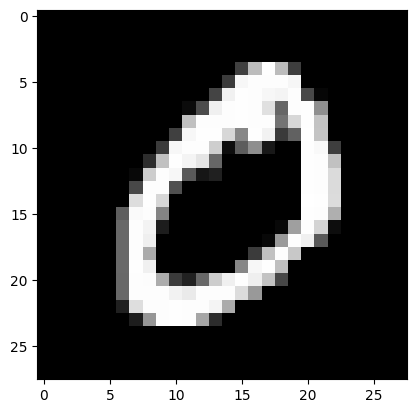

In [38]:
plt.imshow(train_images[1], cmap="Greys_r")

In [32]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [39]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


#Single Linear Model

In [35]:
train_steps = 1000
learning_rate = 0.1

W = tf.Variable(np.zeros([784, 10]).astype(np.float32))
b = tf.Variable(np.zeros(10, dtype=np.float32))


In [36]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        logits = tf.matmul(img_batch, W) + b
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 2.3025853633880615 Accuracy: 0.0859375
Loss: 0.6072514057159424 Accuracy: 0.828125
Loss: 0.5264893770217896 Accuracy: 0.84375
Loss: 0.5064999461174011 Accuracy: 0.84375
Loss: 0.357225239276886 Accuracy: 0.9140625
Starting new epoch...
Loss: 0.48206374049186707 Accuracy: 0.8671875
Loss: 0.42618468403816223 Accuracy: 0.8984375
Loss: 0.39228808879852295 Accuracy: 0.90625
Loss: 0.39353424310684204 Accuracy: 0.859375
Loss: 0.37708163261413574 Accuracy: 0.90625
Starting new epoch...


In [37]:
test_preds = tf.argmax(tf.matmul(data.test_data, W) + b, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.9099, shape=(), dtype=float32)


#Trying bias and weight with random number rather than 0.

In [55]:
train_steps = 1000
learning_rate = 0.1

W = tf.Variable(initial_value=np.random.rand(784, 10), dtype= tf.float32)
b = tf.Variable(initial_value=np.random.rand(1, 10), dtype = tf.float32)

In [59]:
print(np.random.rand(784, 10)[0])

[0.88476865 0.89018703 0.22405178 0.02726407 0.7963819  0.34076886
 0.914778   0.45738455 0.99280806 0.28405051]


In [56]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        logits = tf.matmul(img_batch, W) + b
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 3.9276106357574463 Accuracy: 0.0625
Loss: 0.7936725616455078 Accuracy: 0.7578125
Loss: 0.5452924966812134 Accuracy: 0.8359375
Starting new epoch...
Loss: 0.6472554206848145 Accuracy: 0.796875
Loss: 0.49338507652282715 Accuracy: 0.875
Loss: 0.4988260269165039 Accuracy: 0.828125
Loss: 0.42869287729263306 Accuracy: 0.8984375
Starting new epoch...
Loss: 0.31067389249801636 Accuracy: 0.90625
Loss: 0.4640328288078308 Accuracy: 0.859375
Loss: 0.36461883783340454 Accuracy: 0.8984375


In [57]:
test_preds = tf.argmax(tf.matmul(data.test_data, W) + b, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.8881, shape=(), dtype=float32)


#Not much diff in case of single layer

#Multi layer Neural network - (3 hidden layer)

In [66]:

# Define the number of hidden units for each layer
hidden_units = [256, 128, 64]

#Training step same as single layer
train_steps = 1000
learning_rate = 0.1

W_input = tf.Variable(np.zeros([784, hidden_units[0]]).astype(np.float32))
b_input = tf.Variable(np.zeros(hidden_units[0], dtype=np.float32))

# Weight and bias variables for the first hidden layer
W_hidden1 = tf.Variable(np.zeros([hidden_units[0], hidden_units[1]]).astype(np.float32))
b_hidden1 = tf.Variable(np.zeros(hidden_units[1], dtype=np.float32))

# Weight and bias variables for the second hidden layer
W_hidden2 = tf.Variable(np.zeros([hidden_units[1], hidden_units[2]]).astype(np.float32))
b_hidden2 = tf.Variable(np.zeros(hidden_units[2], dtype=np.float32))

# Weight and bias variables for the output layer
W_output = tf.Variable(np.zeros([hidden_units[2], 10]).astype(np.float32))
b_output = tf.Variable(np.zeros(10, dtype=np.float32))

In [75]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        # Forward pass
        hidden1 = tf.nn.relu(tf.matmul(img_batch, W_input) + b_input)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, W_hidden1) + b_hidden1)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, W_hidden2) + b_hidden2)
        logits = tf.matmul(hidden3, W_output) + b_output

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, [W_input, b_input, W_hidden1, b_hidden1, W_hidden2, b_hidden2, W_output, b_output])
    W_input.assign_sub(learning_rate * grads[0])
    b_input.assign_sub(learning_rate * grads[1])
    W_hidden1.assign_sub(learning_rate * grads[2])
    b_hidden1.assign_sub(learning_rate * grads[3])
    W_hidden2.assign_sub(learning_rate * grads[4])
    b_hidden2.assign_sub(learning_rate * grads[5])
    W_output.assign_sub(learning_rate * grads[6])
    b_output.assign_sub(learning_rate * grads[7])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

# test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
# acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
# print(acc)


Loss: 2.3080732822418213 Accuracy: 0.09375
Loss: 2.2988409996032715 Accuracy: 0.1171875
Loss: 2.302356004714966 Accuracy: 0.140625
Loss: 2.3069143295288086 Accuracy: 0.0859375
Starting new epoch...
Loss: 2.2904953956604004 Accuracy: 0.1640625
Loss: 2.293233871459961 Accuracy: 0.1875
Loss: 2.304719924926758 Accuracy: 0.1015625
Loss: 2.2928009033203125 Accuracy: 0.1796875
Loss: 2.299724817276001 Accuracy: 0.1171875
Starting new epoch...
Loss: 2.303908586502075 Accuracy: 0.1171875


#Low accuracy if we take weights and bias as zeroes - issues of Symmetry,Vanishing Gradients:

#Trying with random weights and bias. 

In [77]:
# Function to initialize weights with random values in the range [-0.1, 0.1]
def initialize_weights(shape):
    return tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=shape).astype(np.float32))

# Function to initialize biases with random values in the range [-0.1, 0.1]
def initialize_biases(shape):
    return tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=shape).astype(np.float32))


In [96]:
hidden_units = [256, 128, 784]
# Initialize weights and biases
W_input = initialize_weights([784, hidden_units[0]])
b_input = initialize_biases([hidden_units[0]])
W_hidden1 = initialize_weights([hidden_units[0], hidden_units[1]])
b_hidden1 = initialize_biases([hidden_units[1]])
W_hidden2 = initialize_weights([hidden_units[1], hidden_units[2]])
b_hidden2 = initialize_biases([hidden_units[2]])
W_output = initialize_weights([hidden_units[2], 10])
b_output = initialize_biases([10])

for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        # Forward pass
        hidden1 = tf.nn.relu(tf.matmul(img_batch, W_input) + b_input)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, W_hidden1) + b_hidden1)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, W_hidden2) + b_hidden2)
        logits = tf.matmul(hidden3, W_output) + b_output

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, [W_input, b_input, W_hidden1, b_hidden1, W_hidden2, b_hidden2, W_output, b_output])
    
    # Update weights and biases
    W_input.assign_sub(learning_rate * grads[0])
    b_input.assign_sub(learning_rate * grads[1])
    W_hidden1.assign_sub(learning_rate * grads[2])
    b_hidden1.assign_sub(learning_rate * grads[3])
    W_hidden2.assign_sub(learning_rate * grads[4])
    b_hidden2.assign_sub(learning_rate * grads[5])
    W_output.assign_sub(learning_rate * grads[6])
    b_output.assign_sub(learning_rate * grads[7])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
print(acc)
#print(grads)

Loss: 2.3284106254577637 Accuracy: 0.0546875
Loss: 0.4395413398742676 Accuracy: 0.859375
Loss: 0.3180759847164154 Accuracy: 0.875
Starting new epoch...
Loss: 0.3246888816356659 Accuracy: 0.90625
Loss: 0.25551339983940125 Accuracy: 0.9296875
Loss: 0.18595102429389954 Accuracy: 0.9453125
Loss: 0.14288140833377838 Accuracy: 0.953125
Starting new epoch...
Loss: 0.1964898705482483 Accuracy: 0.953125
Loss: 0.17829769849777222 Accuracy: 0.953125
Loss: 0.11838220804929733 Accuracy: 0.9765625
tf.Tensor(0.1166, shape=(), dtype=float32)


#This shows that initializing weights with 0 does not work.